In [1]:
import torch
#from torchvision.models.vgg import vgg11
#model = torch.hub.load('./checkpoints/vgg11.pth', 'vgg11', source='local', pretrained=True)

D:\deep_cel_shading\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
vgg = vgg11()
state_dict = torch.load('./checkpoints/vgg11.pth')
vgg.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
newmodel = torch.nn.Sequential(*(list(vgg.children())[:-1]))
print(newmodel)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [2]:
import yaml
from models.dcs_model import instantiate_from_config

config = yaml.safe_load(open('./checkpoints/vae2/config.yaml'))
print("config:")
print(config)
vae = instantiate_from_config(config['model']).cuda()

ckpt = torch.load('./checkpoints/vae2/animevae.pt')
loss = []
for i in ckpt["state_dict"].keys():
    if i[0:4] == "loss":
        loss.append(i)
for i in loss:
    del ckpt["state_dict"][i]

vae.load_state_dict(ckpt["state_dict"])

config:
{'model': {'base_learning_rate': 1.5e-07, 'target': 'ldm.models.autoencoder.AutoencoderKL', 'params': {'monitor': 'val/rec_loss', 'embed_dim': 4, 'ddconfig': {'double_z': True, 'z_channels': 4, 'resolution': 512, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 2, 4, 4], 'num_res_blocks': 2, 'attn_resolutions': [], 'dropout': 0.0}, 'lossconfig': {'target': 'torch.nn.Identity'}}}}
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 64, 64) = 16384 dimensions.
making attention of type 'vanilla' with 512 in_channels


<All keys matched successfully>

In [3]:
from PIL import Image
from numpy import asarray
import torch

def encode_img_latents(imgs):
    #if not isinstance(imgs, list):
    #    imgs = [imgs]
    imgs = imgs / 255.0
    imgs = torch.from_numpy(imgs).float().permute(2, 0, 1).unsqueeze(0)
    imgs = 2 * (imgs - 0.5)

    latent_dists = vae.encode(imgs.cuda())
    latent_samples = latent_dists.mode()
    latent_samples *= 0.18215

    return latent_samples

def decode_img_latents(latents):
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
        imgs = vae.decode(latents)

    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in imgs]
    return pil_images


img = Image.open("sample.png")
img = asarray(img)
latents = encode_img_latents(img)
print(latents.shape)

RuntimeError: Output 0 of SplitBackward0 is a view and is being modified inplace. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.

In [5]:
imgs = decode_img_latents(latents)
len(imgs)

1

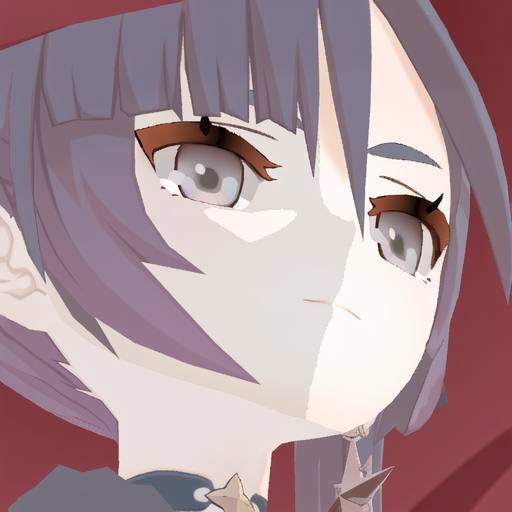

In [6]:
imgs[0]

In [15]:
img = Image.open("sample.png")
img = asarray(img)
img

array([[[148,  69,  78],
        [148,  69,  78],
        [148,  69,  78],
        ...,
        [125,  49,  56],
        [125,  49,  56],
        [125,  49,  56]],

       [[148,  69,  78],
        [148,  69,  78],
        [148,  69,  78],
        ...,
        [125,  49,  56],
        [125,  49,  57],
        [125,  49,  57]],

       [[148,  68,  78],
        [148,  68,  78],
        [148,  69,  78],
        ...,
        [125,  49,  56],
        [125,  49,  56],
        [125,  49,  57]],

       ...,

       [[145,  66,  75],
        [145,  66,  75],
        [145,  66,  75],
        ...,
        [151,  71,  81],
        [151,  70,  81],
        [151,  70,  81]],

       [[146,  66,  75],
        [145,  66,  75],
        [146,  66,  75],
        ...,
        [151,  70,  81],
        [151,  70,  81],
        [151,  69,  81]],

       [[146,  66,  75],
        [146,  66,  75],
        [146,  66,  76],
        ...,
        [151,  70,  81],
        [151,  69,  81],
        [151,  69,  81]]

In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()

<a href="https://colab.research.google.com/github/bkkaggle/pytorch-CycleGAN-and-pix2pix/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [ ]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

# Datasets

Download one of the official datasets with:

-   `bash ./datasets/download_pix2pix_dataset.sh [cityscapes, night2day, edges2handbags, edges2shoes, facades, maps]`

Or use your own dataset by creating the appropriate folders and adding in the images. Follow the instructions [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/datasets.md#pix2pix-datasets).

In [ ]:
!bash ./datasets/download_pix2pix_dataset.sh facades

# Pretrained models

Download one of the official pretrained models with:

-   `bash ./scripts/download_pix2pix_model.sh [edges2shoes, sat2map, map2sat, facades_label2photo, and day2night]`

Or add your own pretrained model to `./checkpoints/{NAME}_pretrained/latest_net_G.pt`

In [ ]:
!bash ./scripts/download_pix2pix_model.sh facades_label2photo

# Training

-   `python train.py --dataroot ./datasets/facades --name facades_pix2pix --model pix2pix --direction BtoA`

Change the `--dataroot` and `--name` to your own dataset's path and model's name. Use `--gpu_ids 0,1,..` to train on multiple GPUs and `--batch_size` to change the batch size. Add `--direction BtoA` if you want to train a model to transfrom from class B to A.

In [1]:
!python train.py --dataroot ./datasets/cel --name cel_shading --model pix2pix --display_id -1

C:\Users\yaros\AppData\Roaming\Python\Python310\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  device: torch.device = torch.device("cpu"),
Traceback (most recent call last):
  File "D:\deep_cel_shading\pytorch-CycleGAN-and-pix2pix\train.py", line 25, in <module>
    from util.visualizer import Visualizer
  File "D:\deep_cel_shading\pytorch-CycleGAN-and-pix2pix\util\visualizer.py", line 6, in <module>
    from . import util, html
  File "D:\deep_cel_shading\pytorch-CycleGAN-and-pix2pix\util\html.py", line 1, in <module>
    import dominate
ModuleNotFoundError: No module named 'dominate'


# Testing

-   `python test.py --dataroot ./datasets/facades --direction BtoA --model pix2pix --name facades_pix2pix`

Change the `--dataroot`, `--name`, and `--direction` to be consistent with your trained model's configuration and how you want to transform images.

> from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix:
> Note that we specified --direction BtoA as Facades dataset's A to B direction is photos to labels.

> If you would like to apply a pre-trained model to a collection of input images (rather than image pairs), please use --model test option. See ./scripts/test_single.sh for how to apply a model to Facade label maps (stored in the directory facades/testB).

> See a list of currently available models at ./scripts/download_pix2pix_model.sh

In [ ]:
!ls checkpoints/

In [ ]:
!python test.py --dataroot ./datasets/facades --direction BtoA --model pix2pix --name facades_label2photo_pretrained --use_wandb

# Visualize

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/100_fake_B.png')
plt.imshow(img)

In [ ]:
img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/100_real_A.png')
plt.imshow(img)

In [ ]:
img = plt.imread('./results/facades_label2photo_pretrained/test_latest/images/100_real_B.png')
plt.imshow(img)